### Enviroment

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["groq_api_key"] = os.getenv("groq_api_key")

### Model 

In [2]:
from langchain_groq import ChatGroq
model = ChatGroq(model = "openai/gpt-oss-120b")

c:\Git Repository\AI_report_Generator\aienv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Structured_Model

In [3]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict

class section(BaseModel):
    name : str = Field(description= "It will contain topic in this blog")
    description : str = Field(description= "it will contain description of the name/subtitle")

class sections(BaseModel):
    sec : list[section] = Field(description="here we will have complete section")  ## Mistake 1
    
structured_model = model.with_structured_output(sections)

### State

In [4]:
from typing_extensions import Annotated
from typing import operator
class State(TypedDict):
    topic : str
    section : list[section] # Mistake 2
    complete_sections: Annotated[list[str], operator.add] # Mistake 3, here add_message will not work beacuse it concat (HumanMessage, SystemMessage, ToolMessage). but operator.add will concat list 
    report : str
    final : str

### Node

In [5]:
from langchain_core.messages import HumanMessage,SystemMessage
from langgraph.types import Send

def get_sections(state:State):
    response = structured_model.invoke([SystemMessage(content=("You are an expert technical blog writer. ""Your task is to generate a clean, well-structured blog outline using the provided schema. ""Each item in the 'sec' list represents one section of the blog. ""For every section, provide: \n""1. 'name' → the section title\n""2. 'description' → a clear, concise explanation of what will be written in that section.\n\n""Guidelines:\n""- Begin with an introductory section.\n""- Follow with 4–8 logical sections covering the full topic.\n""- Keep descriptions short but meaningful (2–4 sentences).\n""- Maintain logical flow from basic to advanced.\n""- Do NOT add content outside the schema. Only return fields defined in the schema.\n""- Output MUST strictly follow the Pydantic 'sections' structure.\n""Wait for the user's query and generate sections accordingly.")),
                                        HumanMessage(content=f"Here is the topic name of my blog {state['topic']}")])
    print(response.sec)
    return {"section" : response.sec}

def each_section_output(state:State):
    response = model.invoke([SystemMessage(content=("You are a professional technical writer. Use Markdown Format to generate. Your job is to generate full blog content ""based strictly on the provided section names and descriptions.\n\n""For each section in the input:\n""- Use the 'name' as the section heading.\n""- Use the 'description' to guide the depth, theme, and direction of writing.\n""- Expand each section into a detailed, well-written explanation (150–300 words per section).\n""- Write in clear, simple, expert-level English.\n""- Do NOT rewrite the outline.\n""- Do NOT add new sections.\n""- Do NOT return JSON.\n""- Only return the final written blog content, properly formatted with headings.\n")),
                             HumanMessage(content=f"here is the name of the subtopic : {state['section'].name} and description is {state['section'].description}")])
    return {"complete_sections" : [response.content]}

def assign_worker(state: State):
    return [Send("each_section_output", {"section": s}) for s in state["section"]]  # Mistake 4

def report(state : State):
    respose = state["complete_sections"]
    res = '\n\n----\n\n'.join(respose)
    return {"report" : res}

def final(state : State):
    response = model.invoke([SystemMessage(content=("You are an expert editor and technical content specialist. Your task is to take the complete blog ""provided by the user and refine it for final publication.\n\n""Your responsibilities:\n""- Improve clarity, flow, and readability without changing the meaning.\n""- Fix grammar, punctuation, and sentence structure.\n""- Enhance transitions between ideas so the blog reads smoothly.\n""- Strengthen the tone to sound polished, professional, and engaging.\n""- Keep all technical details, facts, and structure exactly as provided.\n""- Do NOT add new sections or new concepts.\n""- Do NOT remove user-provided content unless it is repetitive or unclear.\n""- Do NOT alter the factual meaning.\n""- Return ONLY the improved blog text — no explanations, no bullet points, no commentary.\n\n""Your goal is to make the blog feel complete, publication-ready, and professional.")),
                             HumanMessage(content=f"Here is the full blog {state['report']}")])
    return {"final" : response.content}


### StateGraph

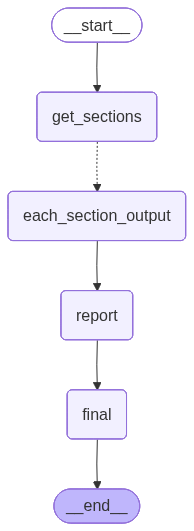

In [6]:
from langgraph.graph import StateGraph, START, END
from IPython.display import display,Image

graph = StateGraph(State)

graph.add_node("get_sections", get_sections)
graph.add_node("each_section_output", each_section_output)
graph.add_node("report", report)
graph.add_node("final", final)

graph.add_edge(START, "get_sections")
graph.add_conditional_edges("get_sections", assign_worker, ["each_section_output"]) ## Mistake 5
graph.add_edge("each_section_output", "report")
graph.add_edge("report","final")
graph.add_edge("final", END)

graph = graph.compile()

image = graph.get_graph().draw_mermaid_png()
display(Image(image))

In [7]:
response = graph.invoke({"topic" : "Turtle Traders"})

[section(name='Introduction to Turtle Traders', description='A brief overview of who the Turtle Traders were, why they matter in trading history, and what readers can expect to learn from this blog.'), section(name='The Origin Story: From a Classroom Experiment to a Legend', description="Describe Richard Dennis and William Eckhardt's experiment, the selection of the original 20 traders, and the cultural context of the 1980s that set the stage for the Turtle phenomenon."), section(name='Core Philosophy: Trend‑Following and Risk Management', description='Explain the fundamental ideas behind the Turtle approach—capturing long‑term trends, using systematic entry/exit rules, and protecting capital through position sizing and stop‑losses.'), section(name='The Turtle Trading Rules: Entry, Exit, and Position Sizing', description='Detail the specific technical rules (e.g., 20‑day breakout, 55‑day breakout, ATR‑based stops) and the formula for calculating unit size, illustrating how the system w

In [8]:
from IPython.display import Markdown
Markdown(response["final"])

## Introduction to Turtle Traders  

The Turtle Traders were a legendary group of systematic, rule‑based investors assembled in the early 1980s by commodities mogul Richard Dennis and his partner William Eckhardt. Frustrated by the debate over whether great traders are born or made, Dennis wagered that anyone could be taught to trade profitably using a simple, mechanical methodology. He recruited a diverse cohort—from a recent college graduate to a seasoned stockbroker—and immersed them in a rigorous training program that emphasized discipline, risk control, and strict adherence to a set of entry, exit, and position‑sizing rules.  

Why do the Turtles matter? Their experiment produced astonishing results: within a few years the original cohort generated hundreds of millions of dollars in profits, outpacing many traditional discretionary managers. The success demonstrated that a well‑designed, transparent system could remove emotion from the decision‑making process, offering a replicable path to consistent returns. Moreover, the Turtle methodology laid the groundwork for modern quantitative and algorithmic trading, influencing everything from trend‑following funds to retail chart‑based strategies.  

In this blog you’ll discover the origins of the Turtle experiment, the core principles that powered their trades, and how those timeless concepts can be applied to today’s markets. Whether you’re a novice looking for a solid foundation or an experienced trader seeking to refine your systematic approach, the lessons from the Turtle Traders provide a compelling blueprint for disciplined, data‑driven investing.  

---  

## The Origin Story: From a Classroom Experiment to a Legend  

In the early 1980s, two seemingly disparate worlds collided on the floor of a modest New York trading firm: the raw, competitive spirit of the commodities market and the disciplined rigor of academic research. Richard Dennis, a self‑made commodities tycoon who turned a modest $1,600 into a multi‑million‑dollar fortune, believed that trading success was a skill that could be taught. His partner, William Eckhardt, a mathematically minded former physicist, shared this conviction but insisted on a systematic, rule‑based approach. Together they designed a bold experiment to prove that anyone could be trained to trade profitably if given the right framework.  

The experiment began in 1983 with a simple yet provocative premise: recruit a diverse group of individuals with little to no trading experience, teach them a concise set of entry, exit, and risk‑management rules, and see whether they could consistently beat the market. From a pool of applicants that included a college professor, a busboy, a stock‑brokerage clerk, and even a professional tennis player, Dennis and Eckhardt selected twenty participants—later dubbed the “Turtles.” The selection process emphasized traits such as discipline, emotional stability, and a willingness to follow rules, rather than prior financial knowledge.  

The cultural backdrop of the 1980s amplified the experiment’s resonance. Wall Street was awash with stories of daring speculators, leveraged buyouts, and the rise of computer‑driven trading. At the same time, a growing fascination with behavioral psychology and the “self‑made man” myth permeated popular media. This era’s optimism about quantifiable success and the belief that systematic methods could tame market chaos created fertile ground for the Turtle experiment to capture imaginations. Within months, the newly minted Turtles began posting impressive returns, turning a classroom‑style training session into a legendary chapter of financial history that still influences modern systematic trading strategies.  

---  

## Core Philosophy: Trend‑Following and Risk Management  

The Turtle trading system is built on a simple yet powerful premise: markets tend to move in sustained, directional waves, and a disciplined trader can profit by riding those waves while keeping losses tightly controlled. At its heart, the approach seeks to **capture long‑term trends** rather than chase short‑term noise. By focusing on multi‑day breakouts—typically the 20‑day high for entries and the 10‑day low for exits—the system filters out fleeting price fluctuations and positions the trader on the side of the prevailing market momentum.  

To translate this philosophy into action, the Turtles rely on **systematic entry and exit rules** that are entirely rule‑based and free of discretion. When price exceeds a predefined breakout level, a new position is opened; when it falls back below a trailing stop (often a multiple of the market’s average true range), the position is closed. This mechanical framework eliminates emotional bias, ensuring that every trade follows the same logical pattern regardless of market conditions.  

Equally essential is the **risk‑management** component, which protects capital and preserves the ability to stay in the game. Position sizing is calculated using the “N” volatility measure, so that each trade risks a fixed percentage (commonly 1–2 %) of the account equity, regardless of the instrument’s price level. Stop‑losses are placed a few “N” units away from entry, giving the market enough room to move while capping potential losses. By combining consistent trend capture with disciplined sizing and stop‑loss controls, the Turtle methodology creates a robust, repeatable system that can thrive across diverse markets and time periods.  

---  

## The Turtle Trading Rules: Entry, Exit, and Position Sizing  

The Turtle system was built on a handful of crystal‑clear, mechanically driven rules that anyone could follow without discretion. **Entry** is triggered by a pure price breakout: a long position is opened when today’s high exceeds the highest high of the previous 20 trading days (the “20‑day breakout”). Conversely, a short is entered when today’s low falls below the lowest low of the prior 20 days. A secondary, slower entry filter uses a 55‑day breakout; the Turtles would only add to an existing position if price broke the 55‑day high (or low), allowing the strategy to capture longer trends while avoiding premature entries on choppy moves.  

**Exit** is equally rule‑based. The primary exit uses a 10‑day low (for longs) or high (for shorts) as a stop‑out, while a secondary exit employs a 20‑day low/high. In addition, each position is protected by an **ATR‑based stop**: the stop is placed a multiple (usually 2 × ATR) away from the entry price, where ATR (Average True Range) is calculated over the past 14 days. This volatility‑adjusted stop scales with market noise, tightening in calm periods and loosening when markets are more erratic.  

**Position sizing** is the heart of the Turtle’s risk control. First, the system computes the “N” value, the 20‑day ATR, which measures the instrument’s typical price movement. The dollar risk per trade is fixed at 1 % of total equity. The **unit size** (number of contracts or shares) is then:  

\[
\text{Unit Size} = \frac{0.01 \times \text{Equity}}{N}
\]  

If the trade moves favorably, the Turtles add up to a maximum of four additional units at each 0.5 N price move, but they never exceed a total exposure of 2 % of equity. All calculations are performed automatically, ensuring the system remains fully mechanical—no judgment calls, no subjective tweaks. This disciplined framework allowed the original Turtles to trade a diversified basket of futures with consistent risk and repeatable performance.  

---  

## Performance Review: Results, Statistics, and Criticisms  

The original Turtle Trading experiment, launched in 1983 by Richard Dennis and William Eckhardt, produced a striking record that still serves as a benchmark for systematic trend‑following. Over the 22‑year test period (1983‑2004) the Turtle portfolio generated an annualized compound growth rate (CAGR) of roughly **30 %**, far outpacing the S&P 500’s average return of about 10 % in the same window. Risk‑adjusted performance was equally impressive: the strategy’s Sharpe ratio hovered around **1.5–2.0**, indicating that each unit of volatility delivered well over one unit of excess return.  

Key to these results was the disciplined use of volatility‑based position sizing and a strict stop‑loss framework. By scaling each trade to a fixed fraction of the account’s equity (typically 1 %–2 % per unit) and exiting on a 2‑ATR break, the Turtles limited drawdowns to roughly 20 %–30 % of peak equity, even during the severe market crashes of 1987 and 2000. The system’s high turnover—averaging 12–15 trades per year per commodity—allowed it to capture a broad set of trends across 20 futures markets, from currencies to metals.  

Despite the headline numbers, the Turtle methodology has attracted several criticisms. First, the back‑tested results rely heavily on a relatively short, highly trending market environment; performance can deteriorate in sideways or mean‑reverting regimes, where false breakouts trigger losses. Second, the original rules assume deep liquidity and low transaction costs; modern markets with wider spreads or higher commissions can erode the Sharpe ratio. Third, the fixed volatility stop may be too tight in periods of extreme price spikes, leading to premature exits and reduced upside capture. Finally, the strategy’s simplicity can be a double‑edged sword: while easy to implement, it offers limited adaptability to evolving market structures such as algorithmic competition and regulatory changes. Understanding these limitations is essential before applying the Turtle framework to contemporary portfolios.  

---  

## Modern Adaptations and Lessons for Today's Traders  

The Turtle trading system, born in the 1980s as a bold experiment in rule‑based speculation, still resonates in today’s algorithm‑driven markets. Modern traders can now implement the core Turtle principles—breakout entry, position sizing, and systematic exits—using a suite of sophisticated tools that were unimaginable to Richard Dennis and his students.  

First, charting platforms such as TradingView, Thinkorswim, and MetaTrader 5 provide real‑time visualizations of the 20‑day and 55‑day breakout channels that the original Turtles used. With built‑in alerts, a trader can receive instant notifications when price pierces these levels, eliminating the need for manual scanning. Second, cloud‑based backtesting engines (e.g., QuantConnect, Backtrader, and AmiBroker) allow users to replay decades of data, tweak the volatility‑adjusted “N” multiplier, and evaluate risk‑adjusted performance across asset classes—from equities to crypto.  

Beyond technology, the timeless lessons of the Turtle experiment remain the foundation of disciplined trading. The system teaches that **rules trump emotions**; a clear entry, stop‑loss, and exit framework removes the temptation to “second‑guess” the market. It also underscores the importance of **risk management**—the original 1‑2 % per trade rule still protects portfolios against black‑swans. Finally, the Turtles demonstrated that **consistent methodology beats occasional genius**; even modest, statistically sound strategies can compound into substantial wealth when applied with patience and rigor.  

By marrying these enduring principles with modern data feeds, automation, and analytics, today’s traders can revive the Turtle spirit—capturing systematic trends while safeguarding capital in an ever‑more complex marketplace.